In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn import preprocessing

from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Load DataFrame
df = pd.read_csv('/Users/gobinathsindhuja/Desktop/Prospa_assignment/supervised_learning_project/data/saleprice_dataset.csv')
df = pd.DataFrame(df)
df.head()

,Unnamed: 0,Advertised_Date,Sold_Date,Sale_Price,Odometer,Power,Fuel_Urban,Make_Code,Family_Code,Year_Group,Region_Description,Vehicle_Code
0,0,2020-06-24 00:00:00,2020-07-23,46935.54,7756.0,213.0,13.5,JEEP,GRAND,2019,WA,4126136366665310352
1,1,2019-11-21 00:00:00,2020-01-13,60556.34,2200.0,184.0,9.3,JEEP,GRAND,2019,WA,4976226188052338111
2,2,2019-08-21 00:00:00,2019-10-15,39970.00,38674.0,184.0,9.3,JEEP,GRAND,2017,WA,-5679626332524971677
3,3,2019-10-04 00:00:00,2019-11-12,19008.77,54627.0,200.0,13.9,JEEP,CHEROKE,2014,WA,613567331764064986
4,4,2019-04-08 00:00:00,2019-07-16,39545.45,57984.0,184.0,9.3,JEEP,GRAND,2016,WA,8983149599916055195


In [3]:
#Re-index DataFrame so that the 'Sale_Price' column is last
df = df.reindex(columns=["Advertised_Date","Sold_Date","Odometer","Power","Fuel_Urban","Make_Code","Family_Code","Year_Group","Region_Description","Vehicle_Code",'Sale_Price'])

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122595 entries, 0 to 122594
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Advertised_Date     122595 non-null  object 
 1   Sold_Date           122595 non-null  object 
 2   Odometer            122563 non-null  float64
 3   Power               122516 non-null  float64
 4   Fuel_Urban          108789 non-null  float64
 5   Make_Code           122595 non-null  object 
 6   Family_Code         122595 non-null  object 
 7   Year_Group          122595 non-null  int64  
 8   Region_Description  122595 non-null  object 
 9   Vehicle_Code        122595 non-null  int64  
 10  Sale_Price          122595 non-null  float64
dtypes: float64(4), int64(2), object(5)
memory usage: 10.3+ MB


In [5]:
df.shape

(122595, 11)

## Data Cleaning

### 1. Address Missing Values

In [6]:
#Return the column series with the respective of number of null values
df.isnull().sum()

Advertised_Date           0
Sold_Date                 0
Odometer                 32
Power                    79
Fuel_Urban            13806
Make_Code                 0
Family_Code               0
Year_Group                0
Region_Description        0
Vehicle_Code              0
Sale_Price                0
dtype: int64

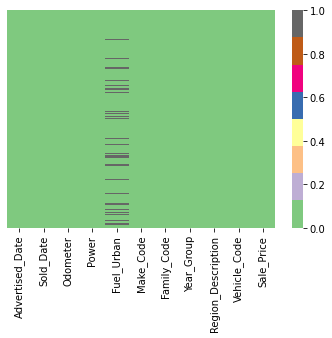

In [7]:
#Generate a heatmap to identify null values along a graph
sns.heatmap(df.isnull(),yticklabels=False,cbar=True,cmap='Accent')
plt.savefig('/Users/gobinathsindhuja/Desktop/Prospa_assignment/supervised_learning_project/assets/img/DataCleanUp/null_values',dpi=None)

In [8]:
#Define categorical variables in order to address them separately
num_col=["Year_Group",'Odometer','Power','Fuel_Urban',"Vehicle_Code"]
cat_cols=['Make_Code','Family_Code','Region_Description']

### 1.1 Iterative Imputation Method for Better Estimation

In [9]:
check_imputer=df.copy()
check_imputer=check_imputer.drop(columns=['Advertised_Date','Sold_Date'])

#Object of LabelEncoder
encoder=preprocessing.LabelEncoder()

#Function to label the categorical columns ignoring null values 
def encode(data):
    #Retains only non-null values
    nonulls = np.array(data.dropna())
    #Reshapes the data for encoding
    impute_reshape = nonulls.reshape(-1,1)
    #Encode date
    impute_ordinal = encoder.fit_transform(impute_reshape)
    #Assign back encoded values to non-null values
    data.loc[data.notnull()] = np.squeeze(impute_ordinal)
    return data

#Loop to replace each column/categorical value with a numberical value
for i in tqdm(range(len(cat_cols))):
    encode(check_imputer[cat_cols[i]])

100%|██████████| 3/3 [00:00<00:00, 26.08it/s]


In [10]:
check_imputer.head()

,Odometer,Power,Fuel_Urban,Make_Code,Family_Code,Year_Group,Region_Description,Vehicle_Code,Sale_Price
0,7756.0,213.0,13.5,29,239,2019,6,4126136366665310352,46935.54
1,2200.0,184.0,9.3,29,239,2019,6,4976226188052338111,60556.34
2,38674.0,184.0,9.3,29,239,2017,6,-5679626332524971677,39970.00
3,54627.0,200.0,13.9,29,117,2014,6,613567331764064986,19008.77
4,57984.0,184.0,9.3,29,239,2016,6,8983149599916055195,39545.45


In [11]:
#Estimate the score of the entire data set by filling in missing values based off of mean and median
br_estimator = BayesianRidge() #Base estimator
N_SPLITS = 6  #Defining the cross-validation splitting strategy

score_simple_imputer = pd.DataFrame() #data frame to store error of imputer
#Computing MSE for mean and median
for strategy in ('mean', 'median'):
    X=check_imputer.iloc[:,:-1]
    y = np.ravel(check_imputer.iloc[:,-1:])
    estimator = make_pipeline(
        SimpleImputer(missing_values=np.nan, strategy=strategy),
        br_estimator
    )
    score_simple_imputer[strategy] = cross_val_score(
        estimator, X, y, scoring='neg_mean_squared_error',
        cv=N_SPLITS
    )

In [12]:
#Fill in missing values using 4 different iterative imputations

#Estimators for IterativeImputer
estimators = [
    BayesianRidge(),
    DecisionTreeRegressor(max_features='sqrt', random_state=0),
    ExtraTreesRegressor(n_estimators=10, random_state=0),
    KNeighborsRegressor(n_neighbors=15)
]
score_iterative_imputer = pd.DataFrame()
for esti in estimators:
        print("Estimating",esti.__class__.__name__)
        imputer = IterativeImputer(esti)
        df_new=check_imputer.copy()
        for col in check_imputer.columns:
            impute_data=imputer.fit_transform(df_new[col].values.reshape(-1,1))
            impute_data=impute_data.astype('int64')
            impute_data = pd.DataFrame(np.ravel(impute_data))
            df_new[col]=impute_data
        X=df_new.iloc[:,:-1]
        y = np.ravel(df_new.iloc[:,-1:])
        score_iterative_imputer[esti.__class__.__name__] = cross_val_score(esti,X,y,scoring='neg_mean_squared_error',cv=6)

Estimating BayesianRidge
Estimating DecisionTreeRegressor
Estimating ExtraTreesRegressor
Estimating KNeighborsRegressor


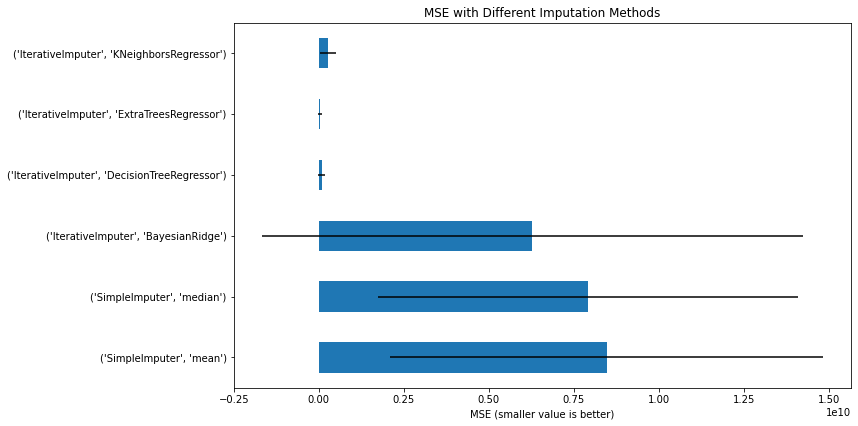

In [13]:
#Plot overall scores for each method
scores = pd.concat(
    [score_simple_imputer, score_iterative_imputer],
    keys=['SimpleImputer', 'IterativeImputer'], axis=1
)
fig, ax = plt.subplots(figsize=(12, 6))
means = -scores.mean()
errors = scores.std()
means.plot.barh(xerr=errors, ax=ax)
ax.set_title('MSE with Different Imputation Methods')
ax.set_xlabel('MSE (smaller value is better)')
ax.set_yticks(np.arange(means.shape[0]))
ax.set_yticklabels(means.index.tolist())
plt.tight_layout(pad=1)
plt.savefig('/Users/gobinathsindhuja/Desktop/Prospa_assignment/supervised_learning_project/assets/img/DataCleanUp/different-imputations-method',dpi=None)
plt.show()

### 1.2 Fill Missing Numerical Values 

In [14]:
df.isnull().sum()[num_col]

Year_Group          0
Odometer           32
Power              79
Fuel_Urban      13806
Vehicle_Code        0
dtype: int64

In [15]:
data_num=df[num_col]
imputer_num=IterativeImputer(estimators[2])
impute_data=imputer_num.fit_transform(data_num)
df[num_col]=impute_data

In [16]:
#Missing values after filling
df.isnull().sum()[num_col]

Year_Group      0
Odometer        0
Power           0
Fuel_Urban      0
Vehicle_Code    0
dtype: int64

### 1.3. Fill Missing Categorical Values

In [17]:
#Missing values before filling
df.isnull().sum()[cat_cols]

Make_Code             0
Family_Code           0
Region_Description    0
dtype: int64

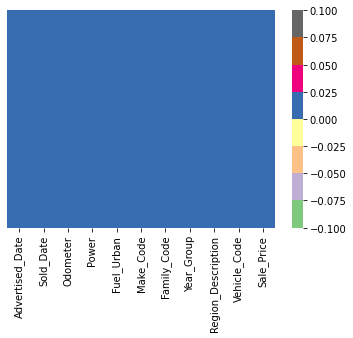

In [18]:
#Heat map to visually check null values
sns.heatmap(df.isnull(),yticklabels=False,cbar=True,cmap='Accent')
plt.savefig('/Users/gobinathsindhuja/Desktop/Prospa_assignment/supervised_learning_project/assets/img/DataCleanUp/no-null-values',dpi=None)

In [19]:
#List method to show no null values in the dataset 
df.isnull().sum()

Advertised_Date       0
Sold_Date             0
Odometer              0
Power                 0
Fuel_Urban            0
Make_Code             0
Family_Code           0
Year_Group            0
Region_Description    0
Vehicle_Code          0
Sale_Price            0
dtype: int64

### 2. Address Outliers

In [20]:
from IPython.display import display,Latex
outliers_condi=Latex(r" $\textbf{Thus $𝑥_1$ or $x_2$ are outliers if }\\ x_1 < Q1 - 1.5*IQR \\ or\\ x_2 > Q3+1.5*IQR $")
outliers_info=Latex(r"$L_{p} = \frac{p}{100}(n+1) = i_p.f_p \\ where \,\, i_p \,\, is \,\, integer \,\, part \,\, of \,\, L_p \,\, and \,\, f_p \,\, is \,\, fractional \,\, part \,\, of \,\, L_p \\ Q1 = Y_{25} = x_{i_p} + f_p*(x_{i_{p+1}}-x_{i_p}) \\ Q3 = Y_{75} = x_{i_p} + f_p*(x_{i_{p+1}}-x_{i_p}) \\ IQR = Q3-Q1 \\ x_1 = Q1 - 1.5*IQR \,\,and\,\, x_2 = Q3+1.5*IQR $")

In [21]:
display(outliers_info)
display(outliers_condi)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [22]:
#Return the range of variables and values outside of this range, ie. outliers
def outliers(arr,col):
    x=sorted(arr[col].values.ravel())
    L_25=25/100*(len(x)+1) #L_p where p=25%
    i_p=int(str(L_25).split(".")[0])
    f_p=int(str(L_25).split(".")[1])
    q1=x[i_p]+f_p*(x[i_p+1]-x[i_p])
    
    L_75=75/100*(len(x)+1) #L_p where p=75%
    i_p=int(str(L_75).split(".")[0])
    f_p=int(str(L_75).split(".")[1])
    q3=x[i_p]+f_p*(x[i_p+1]-x[i_p])
    
    #q1,q3=(arr[col].quantile([0.25,0.75]))
    
    IQR=q3-q1
    x1=q1-1.5*IQR
    x2=q3+1.5*IQR
    return (x1,x2)

### 2.1. Price

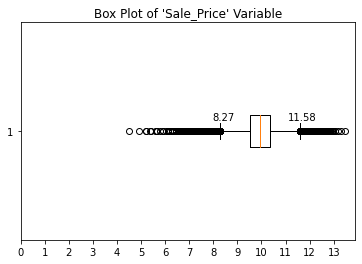

In [23]:
def min_max_price(df):
    r=[]
    q1,q3=(df['logprice'].quantile([0.25,0.75]))
    r.append(q1-1.5*(q3-q1))
    r.append(q3+1.5*(q3-q1))
    return (r)
df['logprice'] = np.log(df['Sale_Price'])
x=df['logprice']
price_range=list(range(0,int(max(df['logprice']))+1))
red_square = dict(markerfacecolor='g', marker='s')
plt.boxplot(x, vert=False)
plt.xticks(price_range)
plt.text(min_max_price(df)[0]-0.3,1.05,str(round(min_max_price(df)[0],2)))
plt.text(min_max_price(df)[1]-0.5,1.05,str(round(min_max_price(df)[1],2)))
plt.title("Box Plot of 'Sale_Price' Variable")
plt.savefig('/Users/gobinathsindhuja/Desktop/Prospa_assignment/supervised_learning_project/assets/img/DataCleanUp/graph-boxplot-price.jpg')
plt.show()

### 2.2. Odometer

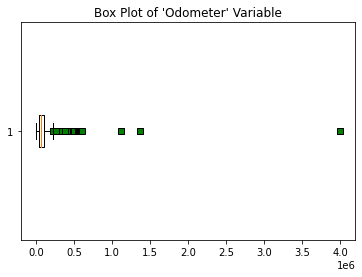

In [24]:
fig, ax1 = plt.subplots()
ax1.set_title("Box Plot of 'Odometer' Variable")
ax1.boxplot(df['Odometer'], vert=False, flierprops=red_square)
plt.savefig('/Users/gobinathsindhuja/Desktop/Prospa_assignment/supervised_learning_project/assets/img/DataCleanUp/graph-boxplot-odometer.jpg')
plt.show()

### 2.3. Year

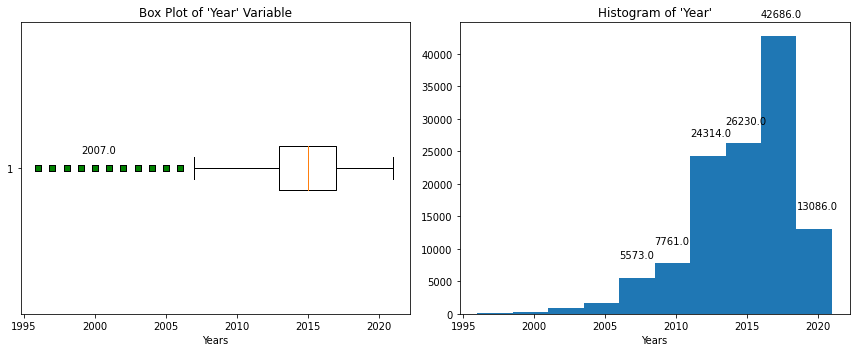

In [25]:
fig,(ax1,ax2)=plt.subplots(ncols=2,figsize=(12,5))

#Plot boxplot
o1,o2=outliers(df,'Year_Group')
ax1.boxplot(sorted(df['Year_Group']), vert=False, flierprops=red_square)
ax1.set_xlabel("Years")
ax1.set_title("Box Plot of 'Year' Variable")
ax1.text(o1-8,1.05,str(round(o1,2)))

#Plot histogram
hist,bins=np.histogram(df['Year_Group'])
n, bins, patches = ax2.hist(x=df['Year_Group'], bins=bins)
ax2.set_xlabel("Years")
ax2.set_title("Histogram of 'Year'")
for i in range(len(n)):
    if(n[i]>2000):
        ax2.text(bins[i],n[i]+3000,str(n[i]))

plt.tight_layout()
plt.savefig('/Users/gobinathsindhuja/Desktop/Prospa_assignment/supervised_learning_project/assets/img/DataCleanUp/graph-boxplot-histogram-year.jpg',dpi=1200)
plt.show()

### 2.4. Power

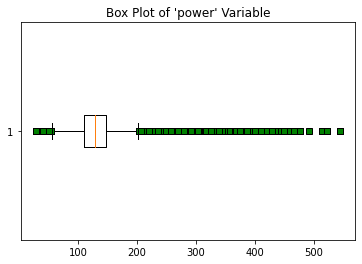

In [26]:
fig, ax1 = plt.subplots()
ax1.set_title("Box Plot of 'power' Variable")
ax1.boxplot(df['Power'], vert=False, flierprops=red_square)
plt.savefig('/Users/gobinathsindhuja/Desktop/Prospa_assignment/supervised_learning_project/assets/img/DataCleanUp/graph-boxplot-power.jpg')
plt.show()

### 2.5. Fuel_Urban

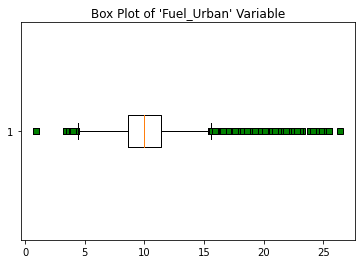

In [27]:
fig, ax1 = plt.subplots()
ax1.set_title("Box Plot of 'Fuel_Urban' Variable")
ax1.boxplot(df['Fuel_Urban'], vert=False, flierprops=red_square)
plt.savefig('/Users/gobinathsindhuja/Desktop/Prospa_assignment/supervised_learning_project/assets/img/DataCleanUp/graph-boxplot-Fuel_Urban.jpg')
plt.show()

In [28]:
#Remove outliers 
df_new=df.copy()
out=np.array(['logprice','Odometer','Year_Group','Power','Fuel_Urban'])
for col in out:
    o1,o2=outliers(df_new,col)
    df_new=df_new[(df_new[col]>=o1) & (df_new[col]<=o2)]
    print('IQR of',col,'=',o1,o2)
df_new=df_new[df_new['Sale_Price']!=0]
df_new.drop('logprice',axis=1,inplace=True)

IQR of logprice = 8.267839610057813 11.58091457458265
IQR of Odometer = -71360.5 221075.5
IQR of Year_Group = 2007.0 2023.0
IQR of Power = 54.5 202.5
IQR of Fuel_Urban = 4.500000000000001 14.899999999999999


In [29]:
df_new.head()

,Advertised_Date,Sold_Date,Odometer,Power,Fuel_Urban,Make_Code,Family_Code,Year_Group,Region_Description,Vehicle_Code,Sale_Price
1,2019-11-21 00:00:00,2020-01-13,2200.0,184.0,9.3,JEEP,GRAND,2019.0,WA,4.976226e+18,60556.34
2,2019-08-21 00:00:00,2019-10-15,38674.0,184.0,9.3,JEEP,GRAND,2017.0,WA,-5.679626e+18,39970.00
3,2019-10-04 00:00:00,2019-11-12,54627.0,200.0,13.9,JEEP,CHEROKE,2014.0,WA,6.135673e+17,19008.77
4,2019-04-08 00:00:00,2019-07-16,57984.0,184.0,9.3,JEEP,GRAND,2016.0,WA,8.983150e+18,39545.45
5,2019-11-13 00:00:00,2019-11-26,88793.0,125.0,9.4,FORD,FOCUS,2014.0,WA,3.705427e+18,8181.82


In [30]:
df_new.shape

(101812, 11)

In [31]:
print("Shape before process=",df.shape)
print("Shape After process=",df_new.shape)
diff=df.shape[0]-df_new.shape[0]
print("Total {} rows and {} cols removed".format(diff,df.shape[1]-df_new.shape[1]))
df_new.to_csv('/Users/gobinathsindhuja/Desktop/Prospa_assignment/supervised_learning_project/data/vehiclesFinal.csv',index=False)

Shape before process= (122595, 12)
Shape After process= (101812, 11)
Total 20783 rows and 1 cols removed
